<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Google-Health/imaging-research/blob/master/cxr-foundation/CXR_Foundation_Demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/CXR_Foundation_Demo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


# CXR Foundation Demo

This notebook demonstrates the richness of information contained in embeddings, generated from full Chest X-Ray images. The contents include how to:

- Download DICOM images and labels from the open-access NIH ChestX-ray14 dataset
- Use the CXR Foundation API to generate image embeddings from the DICOMs
- Train a simple neural network (WITHOUT needing GPU) to detect a medical finding in the embeddings

## Prerequisites

You must have access to use the CXR Foundation API. See the project's [README](https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/README.md) for details.

# [OPTIONAL] Set up Colab to run locally

If you want to run this Colab on your local files, follow the instructions here!

1. Create a Python virtual environment, a local directory that contains all of the dependencies your code needs to run:

        python -m venv env
        source env/bin/activate

2. Install Jupyter and enable the Colab extension (see https://research.google.com/colaboratory/local-runtimes.html):

        pip install jupyter
        pip install jupyter_http_over_ws
        jupyter serverextension enable --py jupyter_http_over_ws
        jupyter notebook \
            --NotebookApp.allow_origin='https://colab.research.google.com' \
            --port=8888 \
            --NotebookApp.port_retries=0

3. In the output of this command, there will be a link that looks like:

        http://localhost:8888/?token=abc12345

  4. Click the the arrow next to "Connect" in the upper right of this screen.
  5. Select "Connect to a local runtime"
  6. Paste the link from the output of the command above.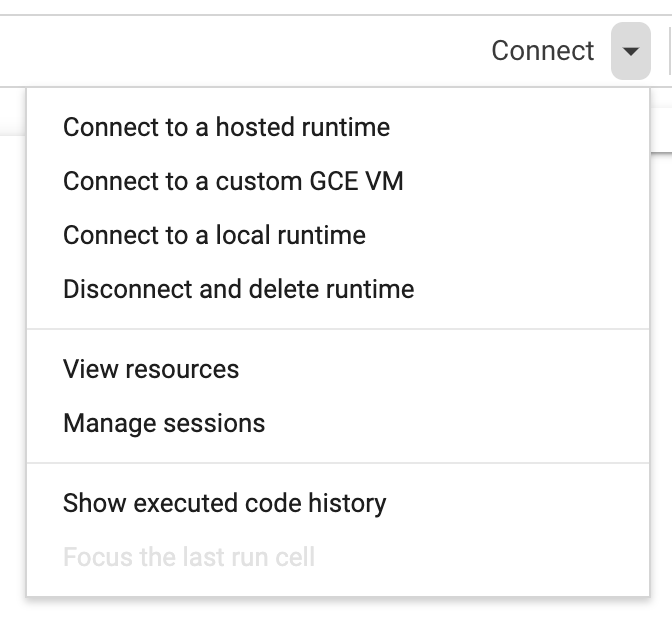

# Installation

Install the CXR Foundation Python Library

In [ ]:
!git clone https://github.com/Google-Health/imaging-research.git
!pip install imaging-research/cxr-foundation/

# Notebook specific dependencies
!pip install matplotlib sklearn

*Did you restart the runtime?*

If you are using Google Colab, the runtime must be restarted after installing new packages.

NOTE: You will have some ERROR messages due to the protobuf library - this is normal.

# Download Data

The NIH ChestX-ray14 dataset, consists of over 100,000 de-identified images of chest x-rays, with fourteen common disease labels, text-mined from the text radiological reports via NLP techniques. The dataset is available on the NIH [download site](https://nihcc.app.box.com/v/ChestXray-NIHCC) and on [Google Cloud](https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest).

The CXR Foundation Demo GCS [bucket](https://console.cloud.google.com/storage/browser/cxr-foundation-demo) contains a subset of the data. We will download the dataset's labels file and some DICOM images below. This might take ~10 minutes or so depending on your connection speed.

In [ ]:
import glob
import io
import os

from google.colab import auth
from google.cloud import storage
import pandas as pd

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [ ]:
# Make a directory to download the data
if not os.path.exists('data'):
  os.mkdir('data')

# Initialize the GCS storage client
storage_client = storage.Client()
bucket = storage_client.get_bucket('cxr-foundation-demo')

# Download and inspect the labels file.
# There is a column for each of several findings, which indicate whether or not
# the condition is present in the image file.
full_labels_df = pd.read_csv(io.BytesIO(bucket.blob('cxr14/labels.csv').download_as_string()))
# DICOM file paths on the data bucket
full_labels_df['remote_dicom_file'] = full_labels_df['image_id'].apply(lambda x: os.path.join('cxr14', 'inputs', x.replace('.png', '.dcm')))
display(full_labels_df.head())

In [ ]:
# Download the DICOM files, organized by the AIRSPACE_OPACITY label.
# Download 100 of each case: positive and negative
DIAGNOSIS = 'AIRSPACE_OPACITY' #@param {type: 'string'}
MAX_CASES_PER_CATEGORY = 100 #@param {type: 'integer'}
DICOM_DIR = './data/inputs' #@param {type: 'string'}
EMBEDDINGS_DIR = './data/outputs' #@param {type: 'string'}

# Labels df of relevant files
df_labels = pd.concat((full_labels_df[full_labels_df[DIAGNOSIS]==0][:100],
                      full_labels_df[full_labels_df[DIAGNOSIS]==1][:100]), ignore_index=True)
df_labels = df_labels[["remote_dicom_file", DIAGNOSIS]]

# Path for downloaded DICOMs
df_labels["dicom_file"] = df_labels["remote_dicom_file"].apply(
    lambda x: os.path.join(DICOM_DIR, os.path.basename(x)))
# Path for generated embeddings
df_labels["embedding_file"] =  df_labels['dicom_file'].apply(
    lambda x: os.path.join(EMBEDDINGS_DIR, os.path.basename(x).replace(".dcm", ".tfrecord")))

df_labels

In [ ]:
if not os.path.exists(DICOM_DIR):
    os.makedirs(DICOM_DIR)

for _, row in df_labels.iterrows():
  blob = bucket.blob(row["remote_dicom_file"])
  if blob.exists():
    blob.download_to_filename(row["dicom_file"])
 
print("Finished downloading DICOM files!")

# Generate Embeddings

**IMPORTANT:** You must have access to use the CXR Foundation API. See the project's [README](https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/README.md) for details.

Generate embeddings (think of them as compressed images) from the downloaded DICOMs. This may take ~15 minutes depending on the load on the server and your connection speed.

*There may be some warnings about "Could not load dynamic library" and or "No project ID could be determined," but these can be safely ignored.*



In [ ]:
if not os.path.exists(EMBEDDINGS_DIR):
  os.makedirs(EMBEDDINGS_DIR)

In [ ]:
!python -m cxr_foundation.run_inference \
  --input_path "{DICOM_DIR}/*.dcm" \
  --output_path "{EMBEDDINGS_DIR}" \
  --input_file_type='dicom' \
  --limit -1  # setting this flag to -1 means unlimited

In [ ]:
# Inspect some embeddings files. A single file is only 5.6kb
from cxr_foundation import embeddings_data


filename = glob.glob(os.path.join(EMBEDDINGS_DIR, '*.tfrecord'))[0]

# Read the tf.train.Example object from the first tfrecord file
example = embeddings_data.read_record_example(filename)
print(example)

# If you don't care about the structure of the .tfrecord file, and/or if
# you don't use Tensorflow, just use the following function to read
# the values directly into a numpy array.
values = embeddings_data.read_record_values(filename)
print(values)

# Prepare Data for Model Training

Separate into training, validation, and testing sets.

In [ ]:
from sklearn.model_selection import train_test_split


df_train, df_validate = train_test_split(df_labels, test_size=0.1)

# Train A Model

Finally, we can train a model using the embeddings! With a simple feed-forward neural network, it should take < 5 minutes to train 100 epochs! No GPU required.

In [ ]:
import tensorflow as tf
import tensorflow_models as tfm


def create_model(heads,
                 embeddings_size=1376,
                 learning_rate=0.1,
                 end_lr_factor=1.0,
                 dropout=0.0,
                 decay_steps=1000,
                 loss_weights=None,
                 hidden_layer_sizes=[512, 256],
                 weight_decay=0.0,
                 seed=None) -> tf.keras.model:
  """
  Creates linear probe or multilayer perceptron using LARS + cosine decay.


  """
  inputs = tf.keras.Input(shape=(embeddings_size,))
  hidden = inputs
  # If no hidden_layer_sizes are provided, model will be a linear probe.
  for size in hidden_layer_sizes:
    hidden = tf.keras.layers.Dense(
        size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(
            hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
  output = tf.keras.layers.Dense(
      units=len(heads),
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(
          hidden)

  outputs = {}
  for i, head in enumerate(heads):
    outputs[head] = tf.keras.layers.Lambda(
        lambda x: x[..., i:i + 1], name=head.lower())(
            output)

  model = tf.keras.Model(inputs, outputs)
  learning_rate_fn = tf.keras.experimental.CosineDecay(
      tf.cast(learning_rate, tf.float32),
      tf.cast(decay_steps, tf.float32),
      alpha=tf.cast(end_lr_factor, tf.float32))
  model.compile(
      optimizer=tfm.optimization.lars.LARS(
          learning_rate=learning_rate_fn),
      loss=dict([(head, 'binary_crossentropy') for head in heads]),
      loss_weights=loss_weights or dict([(head, 1.) for head in heads]),
      weighted_metrics=[
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.AUC(curve='PR', name='auc_pr')])
  return model

In [ ]:
# Create training and validation Datasets
training_data = embeddings_data.get_dataset(filenames=df_train["embedding_file"].values,
                        labels=df_train[DIAGNOSIS].values)


validation_data = embeddings_data.get_dataset(filenames=df_validate["embedding_file"].values,
                        labels=df_validate[DIAGNOSIS].values)

# Create and train the model
model = create_model([DIAGNOSIS])

model.fit(
    x=training_data.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(1).cache(),
    epochs=100,
)

In [ ]:
model.summary()

# Examine metrics

In [ ]:
import sklearn
import matplotlib.pyplot as plt


def plot_curve(x, y, auc, x_label=None, y_label=None, label=None):
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, y, label=f'{label} (AUC: %.3f)' % auc, color='black')
  plt.legend(loc='lower right', fontsize=18)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  if x_label:
    plt.xlabel(x_label, fontsize=24)
  if y_label:
    plt.ylabel(y_label, fontsize=24)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(visible=True)

In [ ]:
rows = []
for embeddings, label in validation_data.batch(1):
  row = {
      f'{DIAGNOSIS}_prediction': model(embeddings)[DIAGNOSIS].numpy().flatten()[0],
      f'{DIAGNOSIS}_value': label.numpy().flatten()[0]
  }
  rows.append(row)
eval_df = pd.DataFrame(rows)

In [ ]:
eval_df.head()

In [ ]:
labels = eval_df[f'{DIAGNOSIS}_value'].values
predictions = eval_df[f'{DIAGNOSIS}_prediction'].values
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
    labels,
    predictions,
    drop_intermediate=False)
auc = sklearn.metrics.roc_auc_score(labels, predictions)
plot_curve(false_positive_rate, true_positive_rate, auc, x_label='False Positive Rate', y_label='True Positive Rate', label=DIAGNOSIS)